# Fine-tune pre-trained model with custom data

In [22]:
from fastai_old.text import *
import html
import spacy 

spacy.load('en')

We're going to grab our custom style text data, e.g. the text of Alice in Wonderland, from the directory `data_style/`. This data tends to be small, so it's included in the repository. We will also create a directory in which we'll store our trained language models, `data_inf/custom_lm/`. This isn't included in the repository because it can be very large.

When we create the language model, we give it a path (in this case `data_inf/custom_lm/`). Then when we save the language model, it saves the data in `path/models/`. 

Note that we'll need to load two files to load the pre-trained data model. These should be located in `data_inf/pretrained/`. The files are `fwd_wt103.h5` and `itos_wt103.pkl`.

Finally, we'll set up a master name for this fine-tuning. The vocab and model will be saved with this name. The default here is `alice`.

In [23]:
DATA_PATH=Path('data_style/')
DATA_PATH.mkdir(exist_ok=True)

LM_PATH = Path('data_inf/custom_lm/')
LM_PATH.mkdir(exist_ok=True)

PRE_PATH=Path('data_inf/pretrained/')
PRE_PATH.mkdir(exist_ok=True)

BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

NAME = 'alice'

Now we're going to load data that is a single text file of plain text. We'll need to split the text into chunks for efficient training and to hold out some data as validation. We'll set a minimum chunk size, and otherwise break at paragraphs.


**TODO: Does it matter that this doesn't break at sentence endings? What are the implications of how we chunk the data?**

In [24]:
minwords = 100

def get_texts(fname):
    texts = []
    with fname.open('r', encoding='utf-8') as f:
        curr = ['', 0]
        for line in f:
            l = len(line.split(' '))
            if curr[1] + l > minwords:
                texts.append(curr[0])
                curr = [line, l]
            else:
                curr[0] += '\n' + line
                curr[1] += l
    if curr[0] != '':
        texts.append(curr[0])
    return np.array(texts)

data_file = NAME + '.txt'
all_texts = get_texts(DATA_PATH/data_file)
len(all_texts)

301

In [25]:
random.choice(all_texts)

'lessons in here? Why, there’s hardly room for YOU, and no room at all\n\nfor any lesson-books!’\n\n\n\nAnd so she went on, taking first one side and then the other, and making\n\nquite a conversation of it altogether; but after a few minutes she heard\n\na voice outside, and stopped to listen.\n\n\n\n‘Mary Ann! Mary Ann!’ said the voice. ‘Fetch me my gloves this moment!’\n\nThen came a little pattering of feet on the stairs. Alice knew it was\n\nthe Rabbit coming to look for her, and she trembled till she shook the\n'

Now we'll split the data into training and validation data. 

**TODO: When there's so little data, stealing some of it for validation seems bad...** 

**Also I was having some issues with the validation set being too small.**

In [26]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    all_texts, test_size=0.3)

len(trn_texts), len(val_texts)

(210, 91)

Using the pandas DataFrame speeds up pre-processing, though it does feel a little like overkill.

In [27]:
col_names = ['text']
df_trn = pd.DataFrame({'text':trn_texts}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts}, columns=col_names)

re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ').replace('.',' .').replace('?',' ?').replace('!',' !').replace('’'," '")
    return re1.sub(' ', html.unescape(x))

def get_texts(df):
    texts = f'\n{BOS} {FLD} 1 ' + df['text'].astype(str)
    texts = list(texts.apply(fixup).values)
    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok

tok_trn = get_texts(df_trn)
tok_val = get_texts(df_val)

len(tok_trn), len(tok_val)

(210, 91)

So I'm changing some stuff here from the IMDb tutorial: I want to keep all the vocab from the pre-trained language model, so I union the vocab of the custom data and the pre-trained model.

**Sike, we are not doing this right now because of the out of memory errors on the GPU, but should come back to this.**

This is partially because I think that makes sense and is cool -- the custom data has a very small vocab (alice.txt is only 1k unique works, I think) but also because I ran into an error when finding the learning rate in which it couldn't normalize because it was all 0s... so maybe having the whole vocab will fix that? We'll see.

In [28]:
freq = Counter(p for o in tok_trn for p in o)

max_vocab = 60000
min_freq = 1

itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

# itos = list(set(itos).union(itos2))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})

trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

itos_file = 'itos_' + NAME + '.pkl'
with open(LM_PATH/itos_file, 'wb') as f:
    pickle.dump(itos, f)

vs=len(itos)
vs

1225

In [15]:
em_sz,nh,nl = 400,1150,3

PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):                     # for word in imbd vocab
    r = stoi2[w]                                # get the int in the pretrained vocab
    new_w[i] = enc_wgts[r] if r>=0 else row_m   # add weight if in vocab, else add mean weight
    
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(LM_PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.model.load_state_dict(wgts)
PRE_LM_PATH

PosixPath('data_inf/pretrained/fwd_wt103.h5')

Now we are in language modeling black magic land, following along with the fast.ai IMDB tutorial. They say to tune the last layer for one epoch first. Suuuure.

In [16]:
learner.metrics = [accuracy]
learner.freeze_to(-1)

lr = 1e-3
lrs = lr

learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

lm_name = NAME + '_lm_last_ft'
learner.save(lm_name)

epoch      trn_loss   val_loss   accuracy                
    0      5.052464   4.873026   0.198165  



And now we're going to fine-tune the whole model. First we're going to find a good learning rate, then unfreeze the whole thing (I think...) and fine-tune.

There is probably some smarter stuff to do here; it's worth checking out the actual [ULMFiT code](https://github.com/fastai/fastai/tree/master/courses/dl2/imdb_scripts) to see what they did there.

In [18]:
num_epochs = 2
learner.unfreeze()
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=num_epochs)
lm_name = NAME + '_lm_' + str(num_epochs) + 'epochs'
learner.save(lm_name)

epoch      trn_loss   val_loss   accuracy                
    0      4.574136   3.908129   0.264512  



epoch      trn_loss   val_loss   accuracy                
    0      4.679891   4.042638   0.263588  
    1      4.384809   3.881674   0.280218                



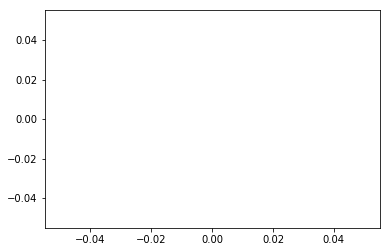

In [20]:
learner.sched.plot_loss()

In [66]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=3)

epoch      trn_loss   val_loss   accuracy                 
    0      6.31212    5.505666   0.218838  
    1      5.852503   5.104173   0.25024                  
    2      5.571883   4.999698   0.257939                 


[4.999697804450989, 0.257938988506794]

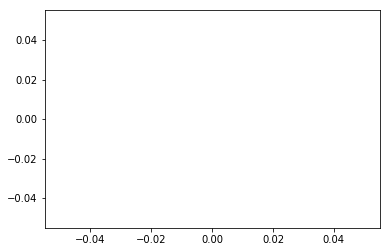

In [67]:
learner.sched.plot_loss()

In [73]:
learner.save('alice1_lm_3epochs')

She 

was not able to get into the room , and she was not able to get the right hand of ...


In [74]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=3)

epoch      trn_loss   val_loss   accuracy                 
    0      4.998464   4.831066   0.271334  
    1      4.832753   4.72177    0.283598                 
    2      4.718088   4.693597   0.289772                 


[4.693597316741943, 0.2897719517350197]

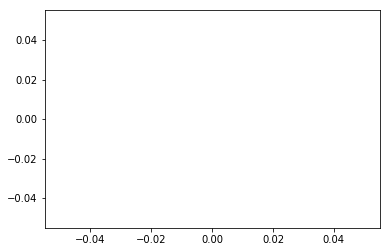

In [75]:
learner.sched.plot_loss()

In [76]:
learner.save('alice1_lm_6epochs')


She 

was not able to find a way to get the attention of the public . she was not sure how ...
